**This notebook contains followings:**
* Data Merging
* Deep Surv


In [9]:
import rpy2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

In [10]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

In [11]:
n_censored = y.shape[0] - y["Status"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


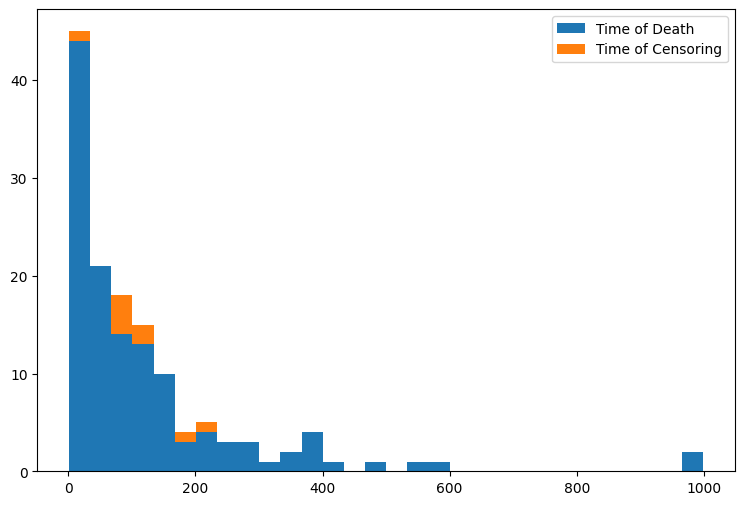

In [12]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_in_days"][y["Status"]],
                               y["Survival_in_days"][~y["Status"]]),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

# Markov model R project

In [21]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

utils = rpackages.importr('utils')

#utils.install_packages('ggm')
#utils.install_packages('survival')

# R package names
packnames = ('ggplot2', 'ggm', 'survival')

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [18]:
pi = robjects.r['pi']
print (pi)

[1] 3.141593



In [24]:
robjects.r('''
        # create a function `f`
        f <- function(r, verbose=FALSE) {
            if (verbose) {
                cat("I am calling f().\n")
            }
            2 * pi * r
        }
        # call the function `f` with argument value 3
        f(3)
        ''')

18.849556


In [44]:
robjects.r('''
        # create a function `f`
        library(ggm)
        library(survival)
        f <- function(r, verbose=FALSE) {
        data(cancer)
        gmm <- ggm(lung[,c(1,3,4,6,7)], type = "mgaussian", lambda = 0.01)
        plot(gmm)
        }
        ''')

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x0000024B75A51880> [RTYPES.CLOSXP]
R classes: ('function',)

In [45]:
r_f = robjects.r['f']
print(r_f.r_repr())
r_f
res = r_f(5)
print (res)

function (r, verbose = FALSE) 
{
    data(cancer)
    gmm <- ggm(lung[, c(1, 3, 4, 6, 7)], type = "mgaussian", 
        lambda = 0.01)
    plot(gmm)
}


<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x0000024B034C5740> [RTYPES.CLOSXP]
R classes: ('function',)

# Markov model PyMSM

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsm.datasets import prep_covid_hosp_data, plot_covid_hosp
from pymsm.multi_state_competing_risks_model import MultiStateModel
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    get_path_frequencies,
    path_total_time_at_states
)
from pymsm.simulation import MultiStateSimulator

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset, state_labels = prep_covid_hosp_data()
plot_covid_hosp(dataset, state_labels)

100%|██████████| 2675/2675 [00:08<00:00, 306.60it/s]


In [4]:
# Some definitions
covariate_cols = ["is_male", "age", "was_severe"]
terminal_states = [4]
state_labels_short = {0: "C", 1: "R", 2: "M", 3: "S", 4: "D"}
print(state_labels)


{1: 'Discharged or Recovered', 2: 'Mild or Moderate', 3: 'Severe', 4: 'Deceased'}


In [5]:
dataset[567].print_path()


Sample id: 577
States: [2 3 4]
Transition times: [ 6 31]
Covariates:
is_male        1.0
age           72.5
was_severe     0.0
Name: 567, dtype: float64


In [6]:
path_freqs = get_path_frequencies(dataset, state_labels_short)
print(path_freqs)


M->R                               1906
M                                   202
M->S                                 76
S->D                                 74
M->S->D                              59
M->S->M->R                           46
M->D                                 44
M->R->M->R                           42
S                                    42
M->R->M                              36
M->S->M                              35
S->M->R                              28
S->M                                 27
M->S->M->S                            8
S->R                                  6
S->M->S                               5
S->M->S->M->R                         3
S->M->D                               3
M->S->M->S->M                         3
M->S->M->S->M->R                      3
M->R->M->R->M->R                      3
M->S->R                               3
S->M->S->D                            2
M->S->M->D                            2
M->R->M->S                            2


In [7]:
def covid_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    covariates = covariates_entering_origin_state.copy()

    # update is_severe covariate
    if origin_state == 3:
        covariates['was_severe'] = 1

    # # update cum_hosp_tim covariate
    # if ((origin_state==2) & (origin_state==3)):
    #     covariates["cum_hosp_time"] += time_at_origin

    return covariates


In [8]:
multi_state_model = MultiStateModel(
    dataset=dataset,
    terminal_states=terminal_states,
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
    state_labels=state_labels,
)


In [9]:
multi_state_model.fit()

Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
>>> Fitting Transition to State: 3, n events: 2
Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\lifelines\utils\__init__.py:1123: ConvergenceWarning: Column is_male have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'is_male'].var())
>>> print(df.loc[~events, 'is_male'].var())

A very low variance means that the column is_male completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\lifelines\fitters\coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.537. This may imply

>>> Fitting Transition to State: 1, n events: 9
>>> Fitting Transition to State: 4, n events: 135


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\lifelines\utils\__init__.py:1123: ConvergenceWarning: Column was_severe have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'was_severe'].var())
>>> print(df.loc[~events, 'was_severe'].var())

A very low variance means that the column was_severe completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\lifelines\fitters\coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.262. Th

In [11]:
multi_state_model.transition_table


target_state,Censored,Discharged or Recovered,Mild or Moderate,Severe,Deceased
origin_state,,,,,
Discharged or Recovered,2044,0,98,2,0
Mild or Moderate,309,2135,0,275,52
Severe,135,9,193,0,135


In [15]:
multi_state_model = MultiStateModel(
    dataset=dataset,
    terminal_states=terminal_states,
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
    state_labels=state_labels,
    trim_transitions_threshold=10
)


In [16]:
multi_state_model.fit()


Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193
>>> Fitting Transition to State: 4, n events: 135


In [17]:
multi_state_model.transition_table()


TypeError: 'DataFrame' object is not callable

In [18]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe":0}),
    origin_state=2,
    current_time=0,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


In [19]:
# Probability of visiting any of the states
for state, state_label in state_labels.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in state_labels.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T


Probabilty of ever being Discharged or Recovered = 0.07
Probabilty of ever being Mild or Moderate = 1.0
Probabilty of ever being Severe = 0.25
Probabilty of ever being Deceased = 1.0


,Discharged or Recovered,Mild or Moderate,Severe
time_in_state_mean,2.360,3.890,0.810
time_in_state_std,9.836,2.486,1.943
time_in_state_median,0.000,3.000,0.000
time_in_state_min,0.000,1.000,0.000
time_in_state_max,64.000,16.000,10.000
time_in_state_quantile_0.1,0.000,1.000,0.000
time_in_state_quantile_0.25,0.000,2.000,0.000
time_in_state_quantile_0.75,0.000,5.250,0.000
time_in_state_quantile_0.9,0.000,7.000,4.000


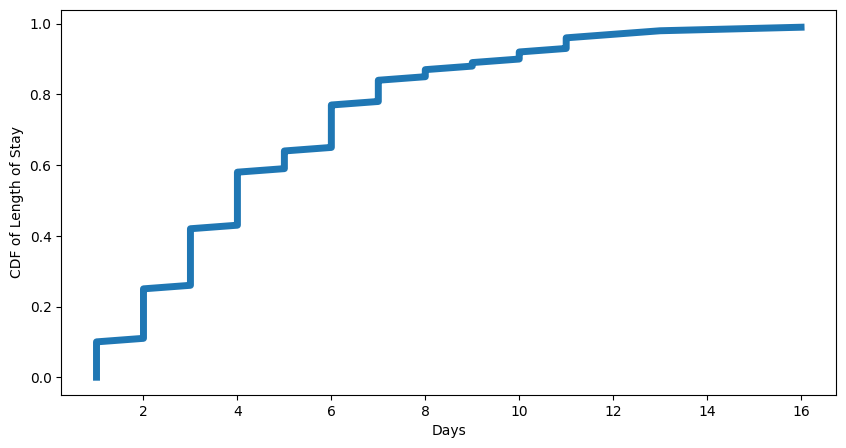

In [20]:
los = np.array([path_total_time_at_states(path, states = [2,3]) for path in mc_paths])

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(np.sort(los), np.linspace(0, 1, len(los), endpoint=False), lw=5)
# ax.set_xlim(0,20)
ax.set_ylabel('CDF of Length of Stay')
ax.set_xlabel('Days');